In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [3]:
import os
all_files = glob.glob('/media/ck/Elements/Africa/WestAfrica/CP4/CP4hist/lsRain/lsRain_*')

months = np.array(['07', '08','09'])#np.array(['06','07','08','09'])#([ '03', '04', '05', '06', '09', '10', '11'])

hist_files = []
#del allhist
for alls in all_files:
    if alls[-11:-9] not in months:
        continue
    else:
        hist_files.append(alls)
#hist_files = all_files

In [4]:
dummy = xr.open_dataset(hist_files[0], decode_times=False).sel(longitude=slice(-19,30), latitude=slice(4,30))
grid = dummy.salem.grid.regrid(factor=0.27) # at 15km
dummy_trans, lut = grid.lookup_transform(dummy['lsRain'], return_lut=True)

In [5]:
histlist = []
for f in hist_files:
    print('Doing', f)
    cph = xr.open_dataset(f, decode_times=False).sel(longitude=slice(-19,30), latitude=slice(4,30))
    prcp = cph['lsRain']*3600
    
    dat_prcp = grid.lookup_transform(prcp, lut=lut, method=np.mean)
    ds = grid.to_dataset()
    prcp = xr.DataArray(dat_prcp, coords=[prcp['time'],ds['y'], ds['x']], dims=['time','latitude','longitude'])
    
    #ipdb.set_trace()
    if prcp.values.ndim != 3:
        continue
#     isin = prcp.max(axis=0)
#     pos = np.where(isin < 5)

    

    prcp = prcp.max(axis=0) #sum
    prcp.values[prcp.values<5] = np.nan
    
    if np.nanmin(prcp.values)<5:
        ipdb.set_trace()
    histlist.append(prcp)
    #plt.contourf(prcp)
    #ipdb.set_trace()
allhist = xr.concat(histlist, dim='dummy', coords='minimal', compat='override')
del cph

Doing /media/ck/Elements/Africa/WestAfrica/CP4/CP4hist/lsRain/lsRain_fullPL__A1hr_mean_ah261_4km_200109090030-200109092330.nc
Doing /media/ck/Elements/Africa/WestAfrica/CP4/CP4hist/lsRain/lsRain_fullPL__A1hr_mean_ad251_4km_199807010030-199807012330.nc
Doing /media/ck/Elements/Africa/WestAfrica/CP4/CP4hist/lsRain/lsRain_fullPL__A1hr_mean_ad251_4km_199807020030-199807022330.nc
Doing /media/ck/Elements/Africa/WestAfrica/CP4/CP4hist/lsRain/lsRain_fullPL__A1hr_mean_ad251_4km_199807030030-199807032330.nc
Doing /media/ck/Elements/Africa/WestAfrica/CP4/CP4hist/lsRain/lsRain_fullPL__A1hr_mean_ad251_4km_199807040030-199807042330.nc
Doing /media/ck/Elements/Africa/WestAfrica/CP4/CP4hist/lsRain/lsRain_fullPL__A1hr_mean_ad251_4km_199807050030-199807052330.nc
Doing /media/ck/Elements/Africa/WestAfrica/CP4/CP4hist/lsRain/lsRain_fullPL__A1hr_mean_ad251_4km_199807060030-199807062330.nc
Doing /media/ck/Elements/Africa/WestAfrica/CP4/CP4hist/lsRain/lsRain_fullPL__A1hr_mean_ad251_4km_199807070030-19980707

KeyboardInterrupt: 

In [ ]:
hm = allhist.quantile(0.95, dim='dummy')
hm.to_netcdf('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_p95Rain_gt5mmDailyMax.nc')

In [ ]:
if np.nanmin(allhist.isel(dummy=slice(1,100))) <1:
    print('SOMETHING WRONG WITH DATA')

In [ ]:
all_files = glob.glob('/media/ck/Elements/Africa/WestAfrica/CP4/CP4fut/lsRain/lsRain_*')
import os
months = np.array(['07', '08','09'])#np.array(['06','07','08','09'])#([ '03', '04', '05', '06', '09', '10', '11'])

fut_files = []
#del allfut
for alls in all_files:
    if alls[-11:-9] not in months:
        continue
    else:
        fut_files.append(alls)
#fut_files = all_files

In [ ]:
futlist = []
for f in fut_files:
    cph = xr.open_dataset(f, decode_times=False).sel(longitude=slice(-20,20), latitude=slice(3.5,25))
    prcp = cph['lsRain']*3600
    
    dat_prcp = grid.lookup_transform(prcp, lut=lut, method=np.mean)
    ds = grid.to_dataset()
    prcp = xr.DataArray(dat_prcp, coords=[prcp['time'],ds['y'], ds['x']], dims=['time','latitude','longitude'])
    
    if prcp.values.ndim != 3:
        continue
    isin = prcp.max(axis=0)
    pos = np.where(isin < 5)

    prcp = prcp.sum(axis=0)
    prcp.values[pos] = np.nan

    if np.nanmin(prcp.values)<5:
        ipdb.set_trace()
    futlist.append(prcp)
allfut = xr.concat(futlist, dim='dummy', coords='minimal', compat='override')
del cph

In [ ]:
fm = allfut.quantile(0.95, dim='dummy')
fm.to_netcdf('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_p95Rain_gt5mm.nc')

In [ ]:
sahel_hist = allhist.sel(latitude=slice(8,12), longitude=slice(-10,10)).values
sahel_fut = allfut.sel(latitude=slice(8,12), longitude=slice(-10,10)).values

In [ ]:
sahel_hist = sahel_hist.flatten()[np.isfinite(sahel_hist.flatten())]
sahel_fut = sahel_fut.flatten()[np.isfinite(sahel_fut.flatten())]

In [ ]:
f = plt.figure(figsize=(13,9), dpi=100)
ax = f.add_subplot(111)
#ipdb.set_trace()
nball, allcount, bins = u_stat.histo_frequency(sahel_hist, bins=np.arange(1, 120, 2))
#ipdb.set_trace()
bin_centre = bins[0:-1] + ((bins[1::] - bins[0:-1]) / 2)
cumulative = np.cumsum(nball)
ax.plot(bin_centre,cumulative, marker='o', markersize=1)

#ipdb.set_trace()
nball, allcount, bins = u_stat.histo_frequency(sahel_fut, bins=np.arange(1, 120, 2))
#ipdb.set_trace()
bin_centre = bins[0:-1] + ((bins[1::] - bins[0:-1]) / 2)
cumulative = np.cumsum(nball)
ax.plot(bin_centre,cumulative,  marker='o', markersize=1)
plt.axhline(0.5, linestyle='dashed', color='k')
plt.axhline(0.8, linestyle='dashed', color='k')
plt.axvline(0.8, linestyle='dashed', color='k')

In [ ]:
hm = xr.open_dataarray('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_p95Rain_gt5mm.nc')
fm = xr.open_dataarray('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_p95Rain_gt5mm.nc')
hm = hm.sel(latitude=slice(3.5,25), longitude=slice(-20,20))
fm = fm.sel(latitude=slice(3.5,25), longitude=slice(-20,20))

In [8]:
def draw_map(ax, dat, lat, lon, title='', levels=None, label=None, cmap=None):
   
    plt.contourf(lon, lat, dat, transform=ccrs.PlateCarree(), extend='both', levels=levels, cmap=cmap)
    ax.coastlines()
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--');
    ax.set_facecolor('lightgrey')
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(label)

In [ ]:
f = plt.figure(figsize=(15,5), dpi=300)

ax = f.add_subplot(221, projection=ccrs.PlateCarree())
draw_map(ax, hm, hm.latitude, hm.longitude, title='Historical P95 daily rain (May-Oct)', levels=np.arange(30,101,10), label=r'mm day$^-1$')
ax1 = f.add_subplot(222, projection=ccrs.PlateCarree())
draw_map(ax1, fm, fm.latitude, fm.longitude, title='Future P95 daily rain (May-Oct)', levels=np.arange(30,101,10), label=r'mm day$^-1$')
ax1 = f.add_subplot(223, projection=ccrs.PlateCarree())
draw_map(ax1, (fm-hm), fm.latitude, fm.longitude, title='Difference P95 rain (Fut-Hist)', levels=np.arange(0,60,10), label=r'mm day$^-1$')
ax1 = f.add_subplot(224, projection=ccrs.PlateCarree())
draw_map(ax1, (fm-hm)/hm*100, fm.latitude, fm.longitude, title='Percentage increase P95 (Fut-Hist/Hist)', levels=[5,10,20,30,40,50,60,70,80], label=r'%')
plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/rory_check/daily_median_percentIncrease_May-Oct.jpg')

In [3]:
tcw_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_tcwv_daily.nc')
tcw_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_tcwv_daily.nc')

In [4]:
u600_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_u600_daily.nc')
u925_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_u925_daily.nc')

u600_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_u600_daily.nc')
u925_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_u925_daily.nc')

In [5]:
tcw_diff = tcw_fut-tcw_hist
shear_diff = (u925_fut-u600_fut) - (u925_hist-u600_hist)
shear_hist =(u925_hist-u600_hist)

In [6]:
tcw_diff = tcw_diff['tcwv'].sel(latitude=slice(3.5,25), longitude=slice(-20,20))
tcw_hist = tcw_hist['tcwv'].sel(latitude=slice(3.5,25), longitude=slice(-20,20))
shear_diff = shear_diff['u_pl'].sel(latitude=slice(3.5,25), longitude=slice(-20,20))
shear_hist = shear_hist['u_pl'].sel(latitude=slice(3.5,25), longitude=slice(-20,20))
# fm = fm.sel(latitude=slice(3.5,25), longitude=slice(-20,20))
# hm = hm.sel(latitude=slice(3.5,25), longitude=slice(-20,20))

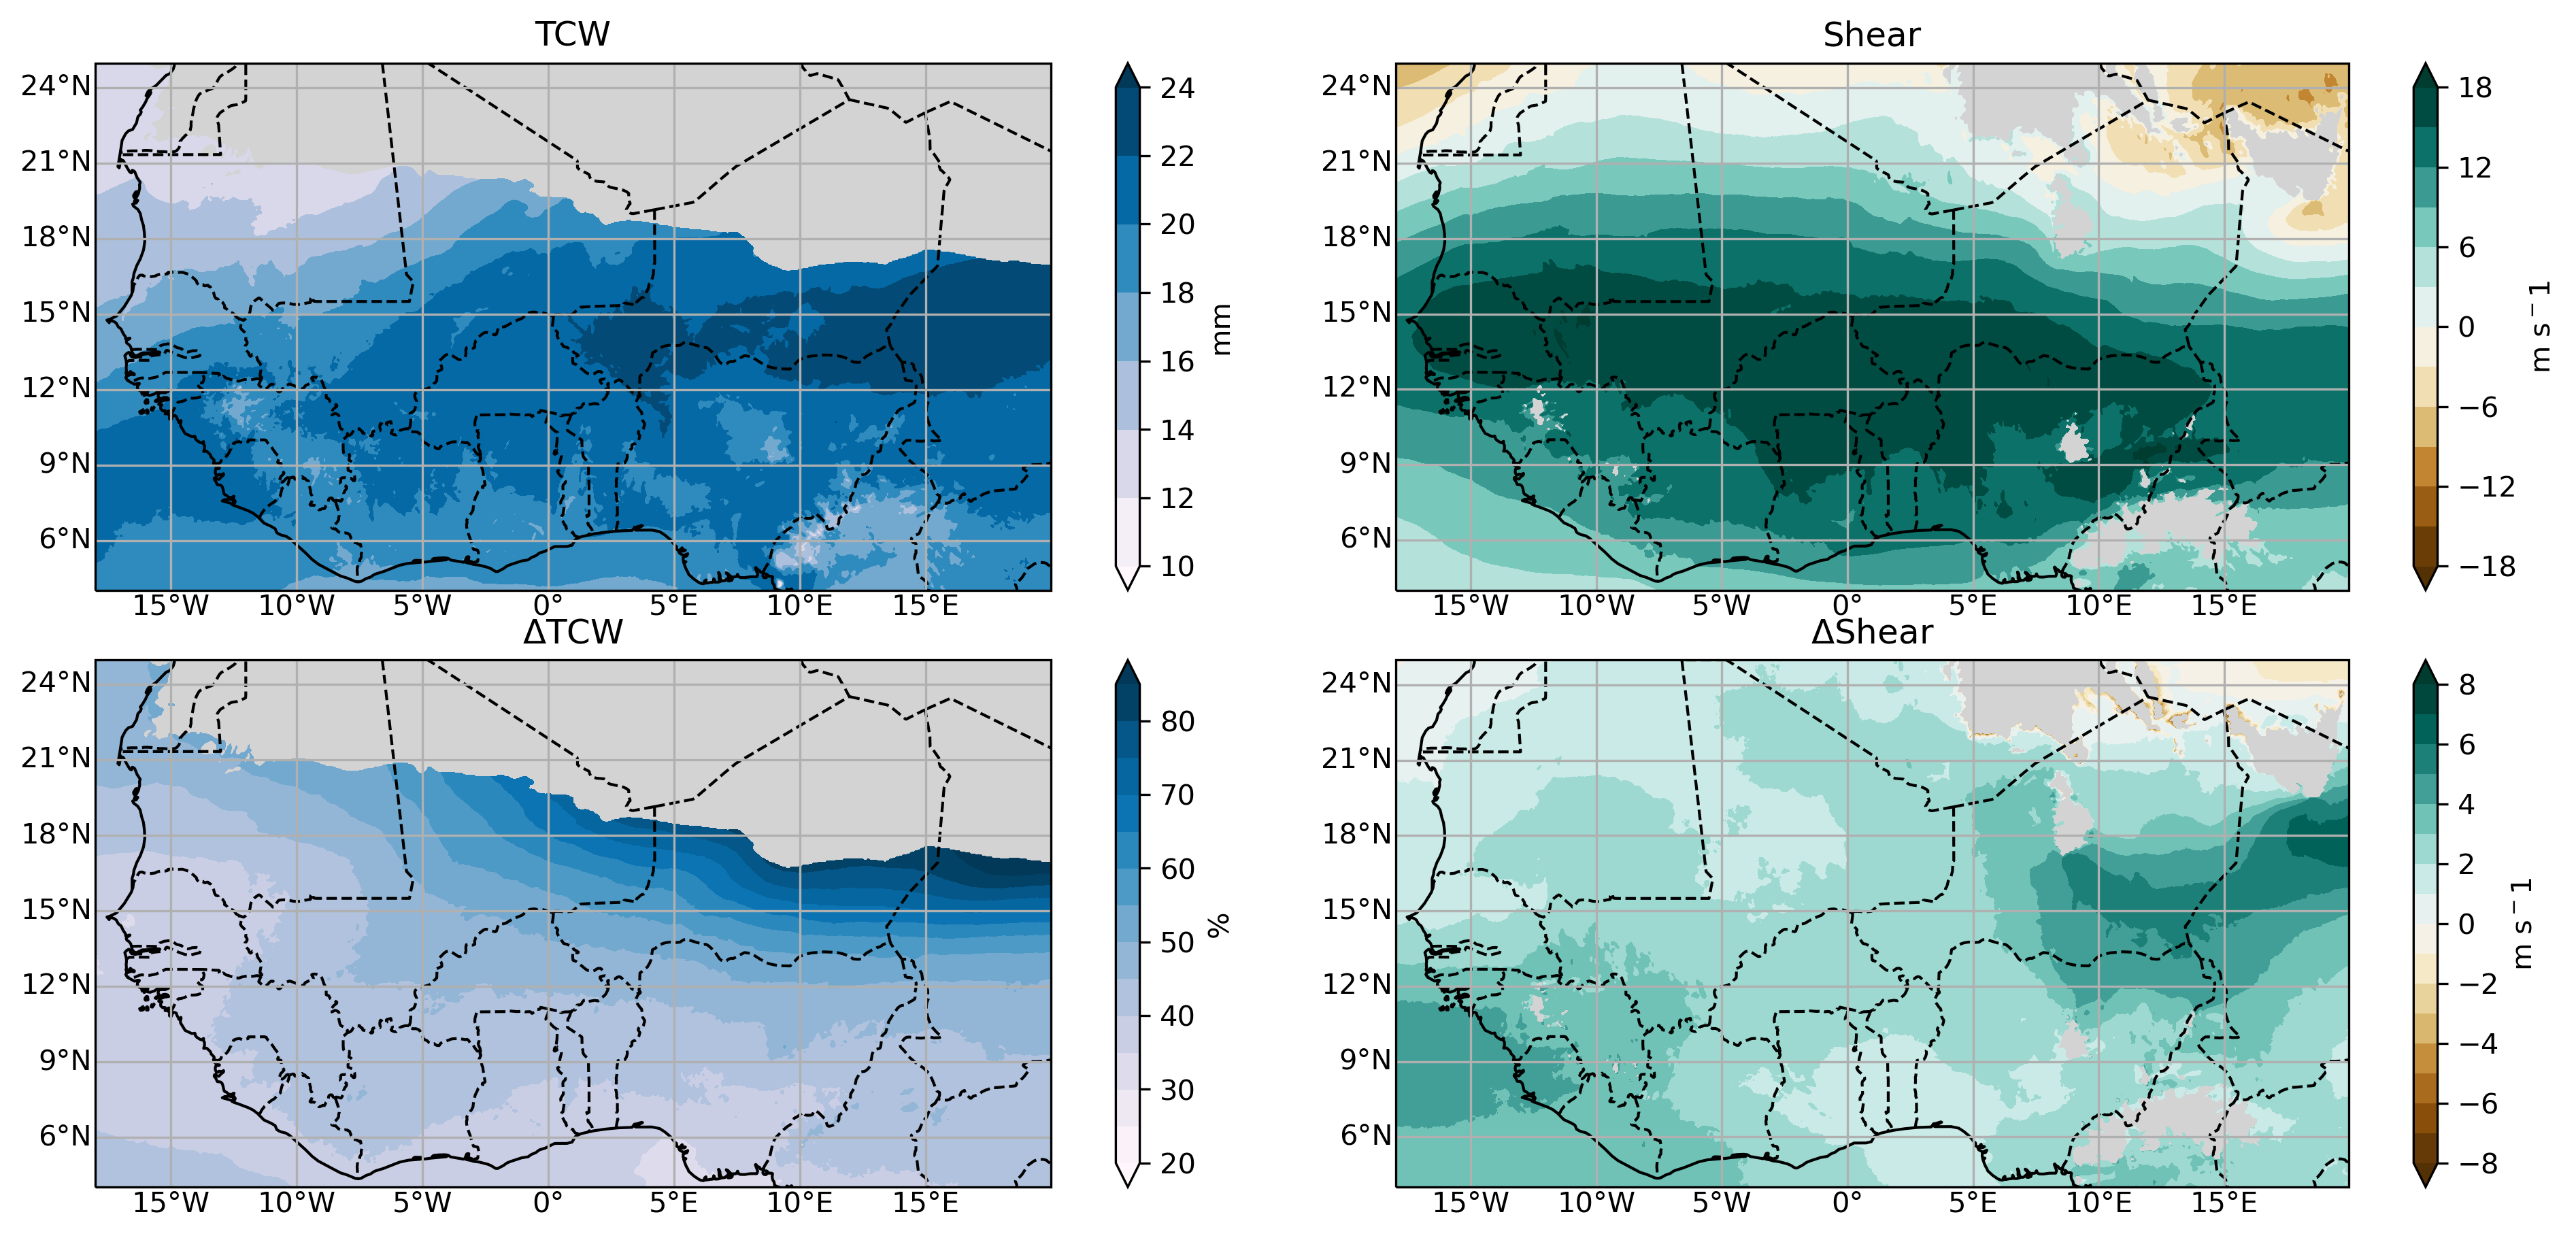

In [12]:
f = plt.figure(figsize=(13,6), dpi=300)

ax2 = f.add_subplot(221, projection=ccrs.PlateCarree())
draw_map(ax2, tcw_diff.where(tcw_hist>25), tcw_diff.latitude, tcw_diff.longitude, title='TCW', levels=np.arange(10,25,2), label=r'mm', cmap='PuBu')
ax3 = f.add_subplot(222, projection=ccrs.PlateCarree())
draw_map(ax3, shear_hist, shear_diff.latitude, shear_diff.longitude, title='Shear', levels=np.arange(-18,19,3), label=r'm s$^-1$', cmap='BrBG')


ax = f.add_subplot(223, projection=ccrs.PlateCarree())
draw_map(ax, tcw_diff.where(tcw_hist>25)/tcw_hist*100, tcw_diff.latitude, tcw_diff.longitude, title='$\Delta$TCW', levels=np.arange(20,90,5), label=r'%', cmap='PuBu')
ax1 = f.add_subplot(224, projection=ccrs.PlateCarree())
draw_map(ax1, shear_diff, shear_diff.latitude, shear_diff.longitude, title='$\Delta$Shear', levels=np.arange(-8,9,1), label=r'm s$^-1$', cmap='BrBG')
plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CP4_TCWSHEAR_baseline.jpg')

In [19]:
tcw_diff.where(tcw_hist['tcwv']>20).shape

(518, 939)

In [22]:
shearfac = 0.71 # monthly: 0.55
tcwvfac = 3.12 # relative change
tcabsfac = 1.22 # absolute change
tcabserrlow = (tcabsfac-2*0.1)
tcabserrhigh = (tcabsfac+2*0.1)
mmPerPercent = tcabsfac/tcwvfac

# tcwvperr = 0.15 #%
# sherr = 0.051 # mm / shear
# shperr = sherr * mmPerPercent

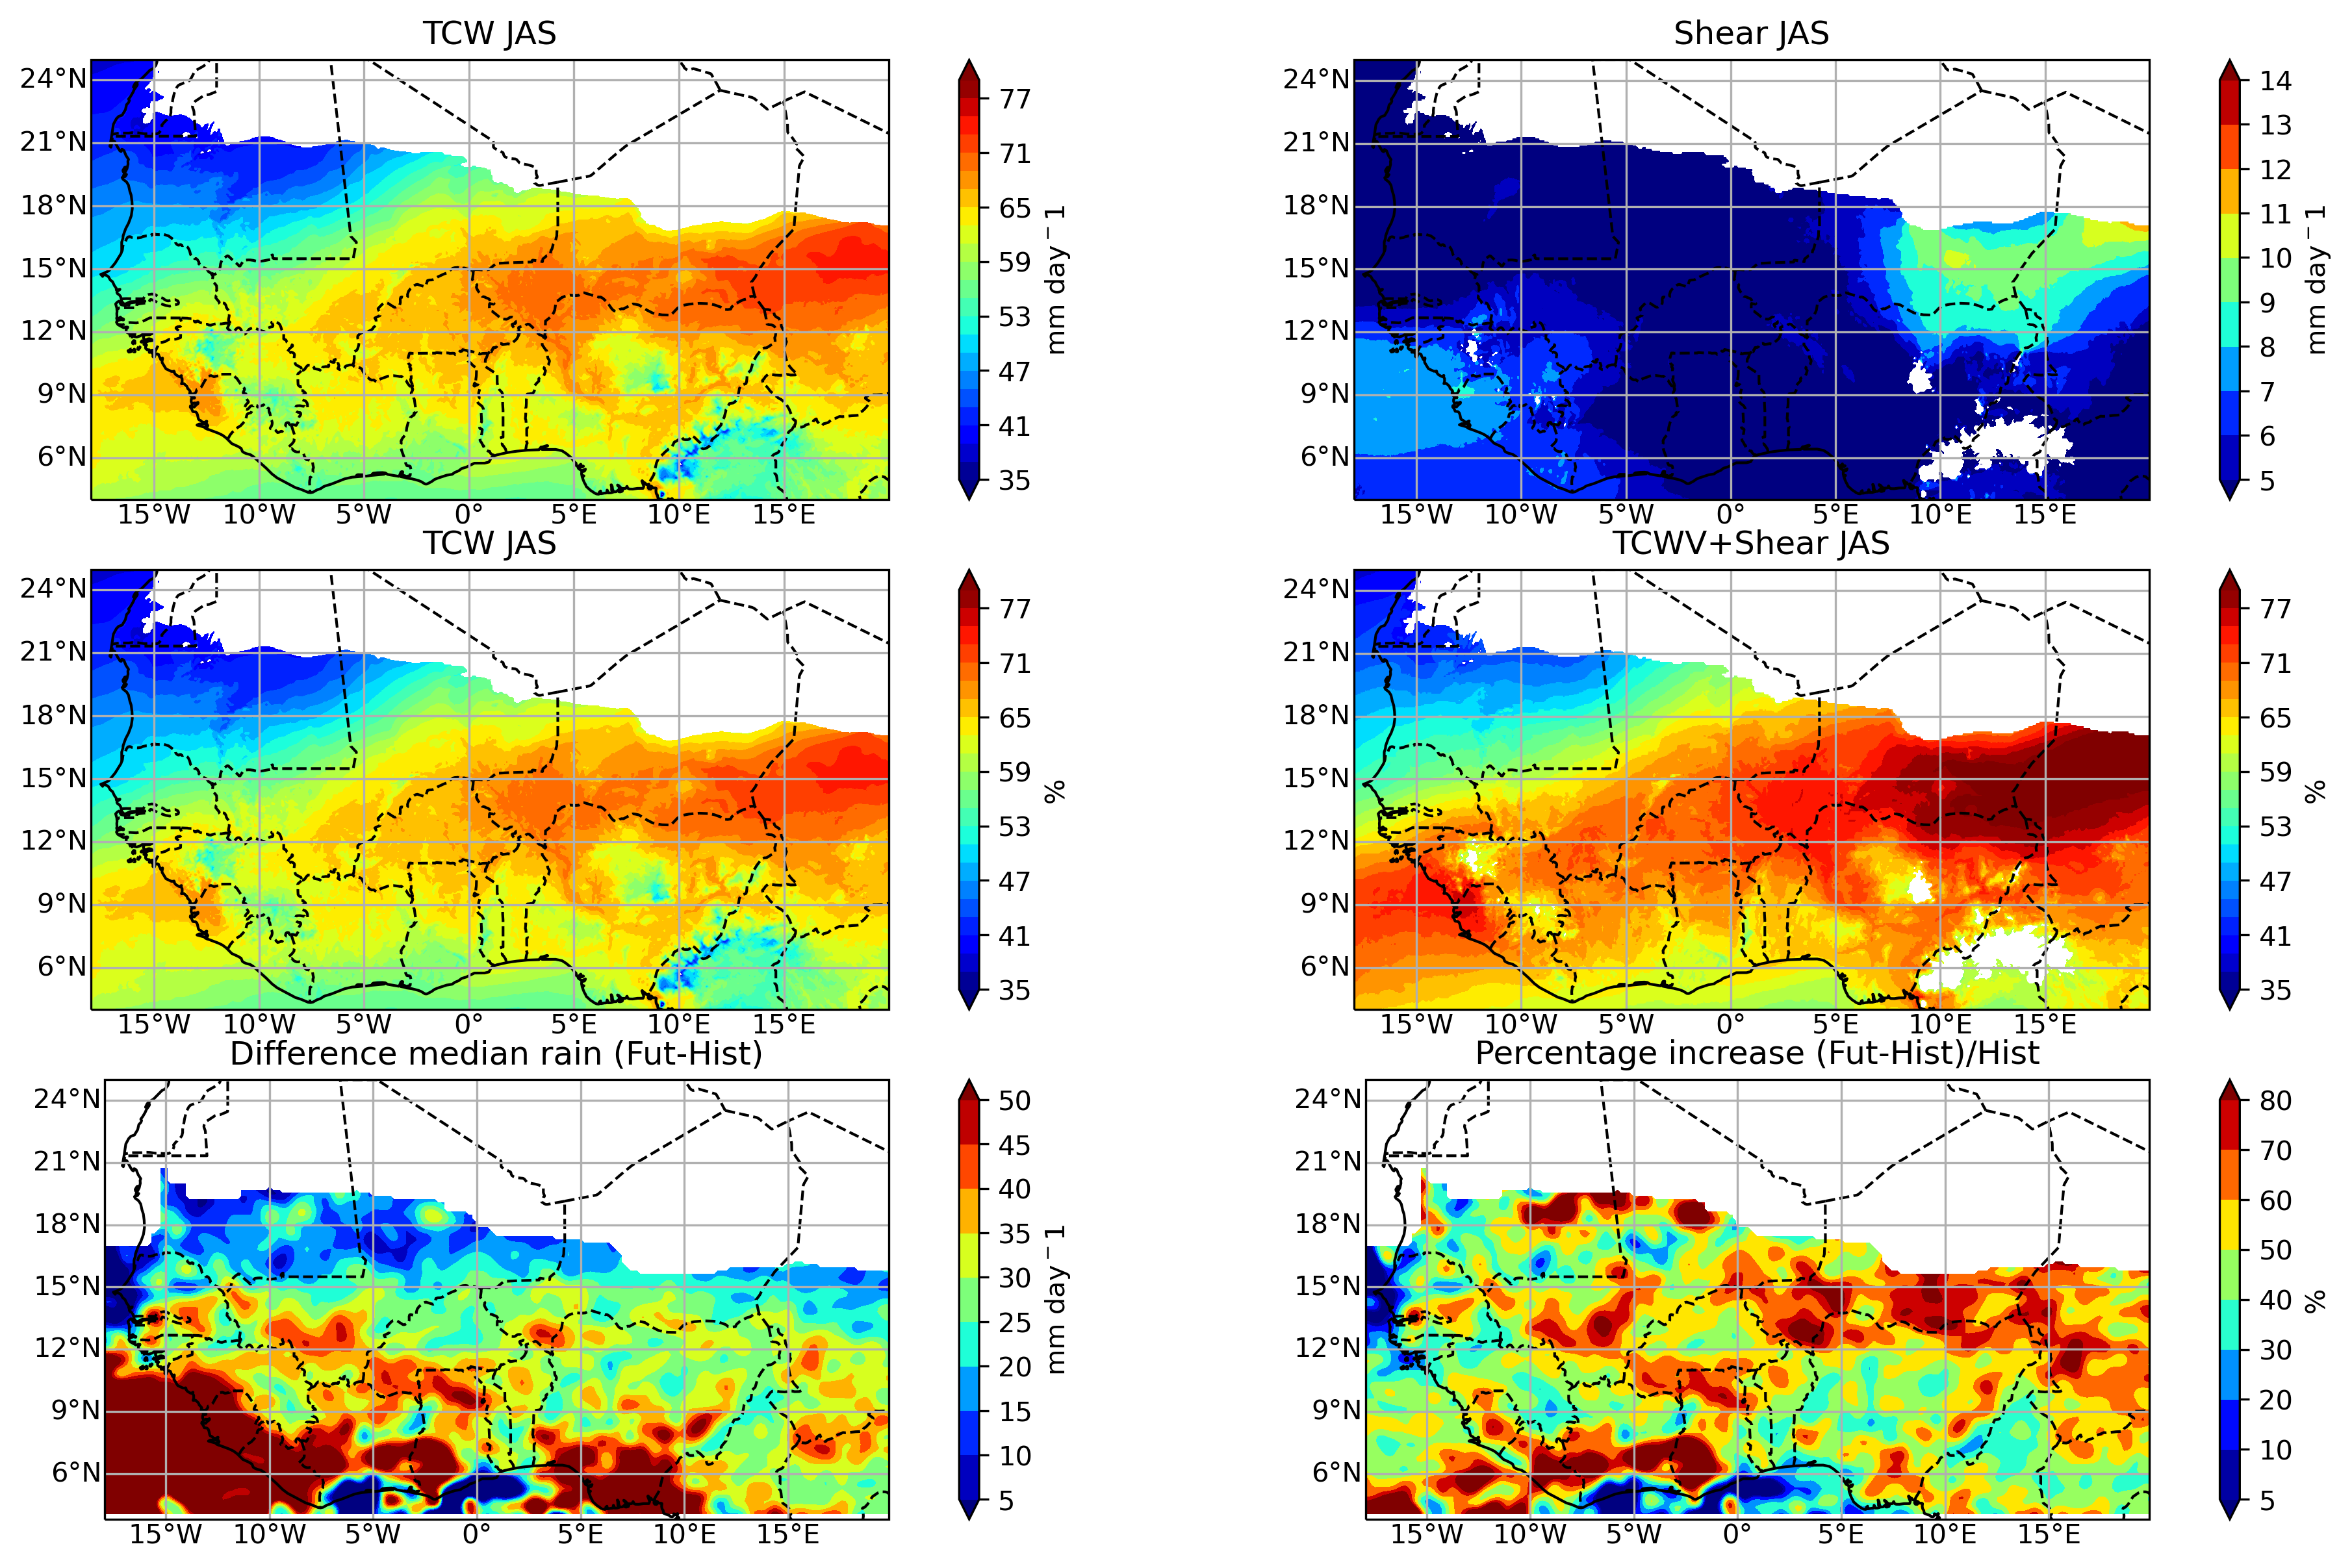

In [42]:
from scipy import ndimage
f = plt.figure(figsize=(14,8), dpi=300)
tthresh = 24.5   # 0.5th centile
thist_on_precip = fm.salem.lookup_transform(tcw_hist['tcwv'])
thist_on_shear = shear_diff.salem.transform(tcw_hist['tcwv'])
tdiff_on_shear = shear_diff.salem.transform(tcw_diff)

#ndimage.gaussian_filter(((dic2['lsta0']) / (dic2['cnt0'])), 2, mode='nearest')

ax = f.add_subplot(321, projection=ccrs.PlateCarree())
draw_map(ax, tcw_diff.where(tcw_hist['tcwv']>tthresh)*tcabsfac/mmPerPercent, tcw_diff.latitude, tcw_diff.longitude, title='TCW JAS', levels=np.arange(35,81,2), label=r'mm day$^-1$')
ax1 = f.add_subplot(322, projection=ccrs.PlateCarree())
draw_map(ax1, shear_diff.where(thist_on_shear>tthresh)*shearfac/mmPerPercent, shear_diff.latitude, shear_diff.longitude, title='Shear JAS', levels=np.arange(5,15,1), label=r'mm day$^-1$')
ax2 = f.add_subplot(323, projection=ccrs.PlateCarree())
draw_map(ax2, tcw_diff.where(tcw_hist['tcwv']>tthresh)*tcabsfac/mmPerPercent, tcw_diff.latitude, tcw_diff.longitude, title='TCW JAS', levels=np.arange(35,81,2), label=r'%')
ax3 = f.add_subplot(324, projection=ccrs.PlateCarree())
draw_map(ax3, ((shear_diff.where(thist_on_shear>tthresh)*shearfac)+(tdiff_on_shear.where(thist_on_shear>tthresh)*tcabsfac))/mmPerPercent, shear_diff.latitude, shear_diff.longitude, title='TCWV+Shear JAS', levels=np.arange(35,81,2), label=r'%')
ax4 = f.add_subplot(325, projection=ccrs.PlateCarree())
ax4.set_ylim(3.8,25)
draw_map(ax4, ndimage.gaussian_filter((fm-hm).where(thist_on_precip>tthresh),2, mode='nearest'), fm.latitude, fm.longitude, title='Difference median rain (Fut-Hist)', levels=[5,10,15,20,25,30,35,40,45,50], label=r'mm day$^-1$')
ax5 = f.add_subplot(326, projection=ccrs.PlateCarree())
ax5.set_ylim(3.8,25)
draw_map(ax5, ndimage.gaussian_filter(((fm-hm)/hm*100).where(thist_on_precip>tthresh),2, mode='nearest'), fm.latitude, fm.longitude, title='Percentage increase (Fut-Hist)/Hist', levels=[5,10,20,30,40,50,60,70,80], label=r'%')
plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/rory_check/daily_median_percentIncrease_May-Oct.jpg')

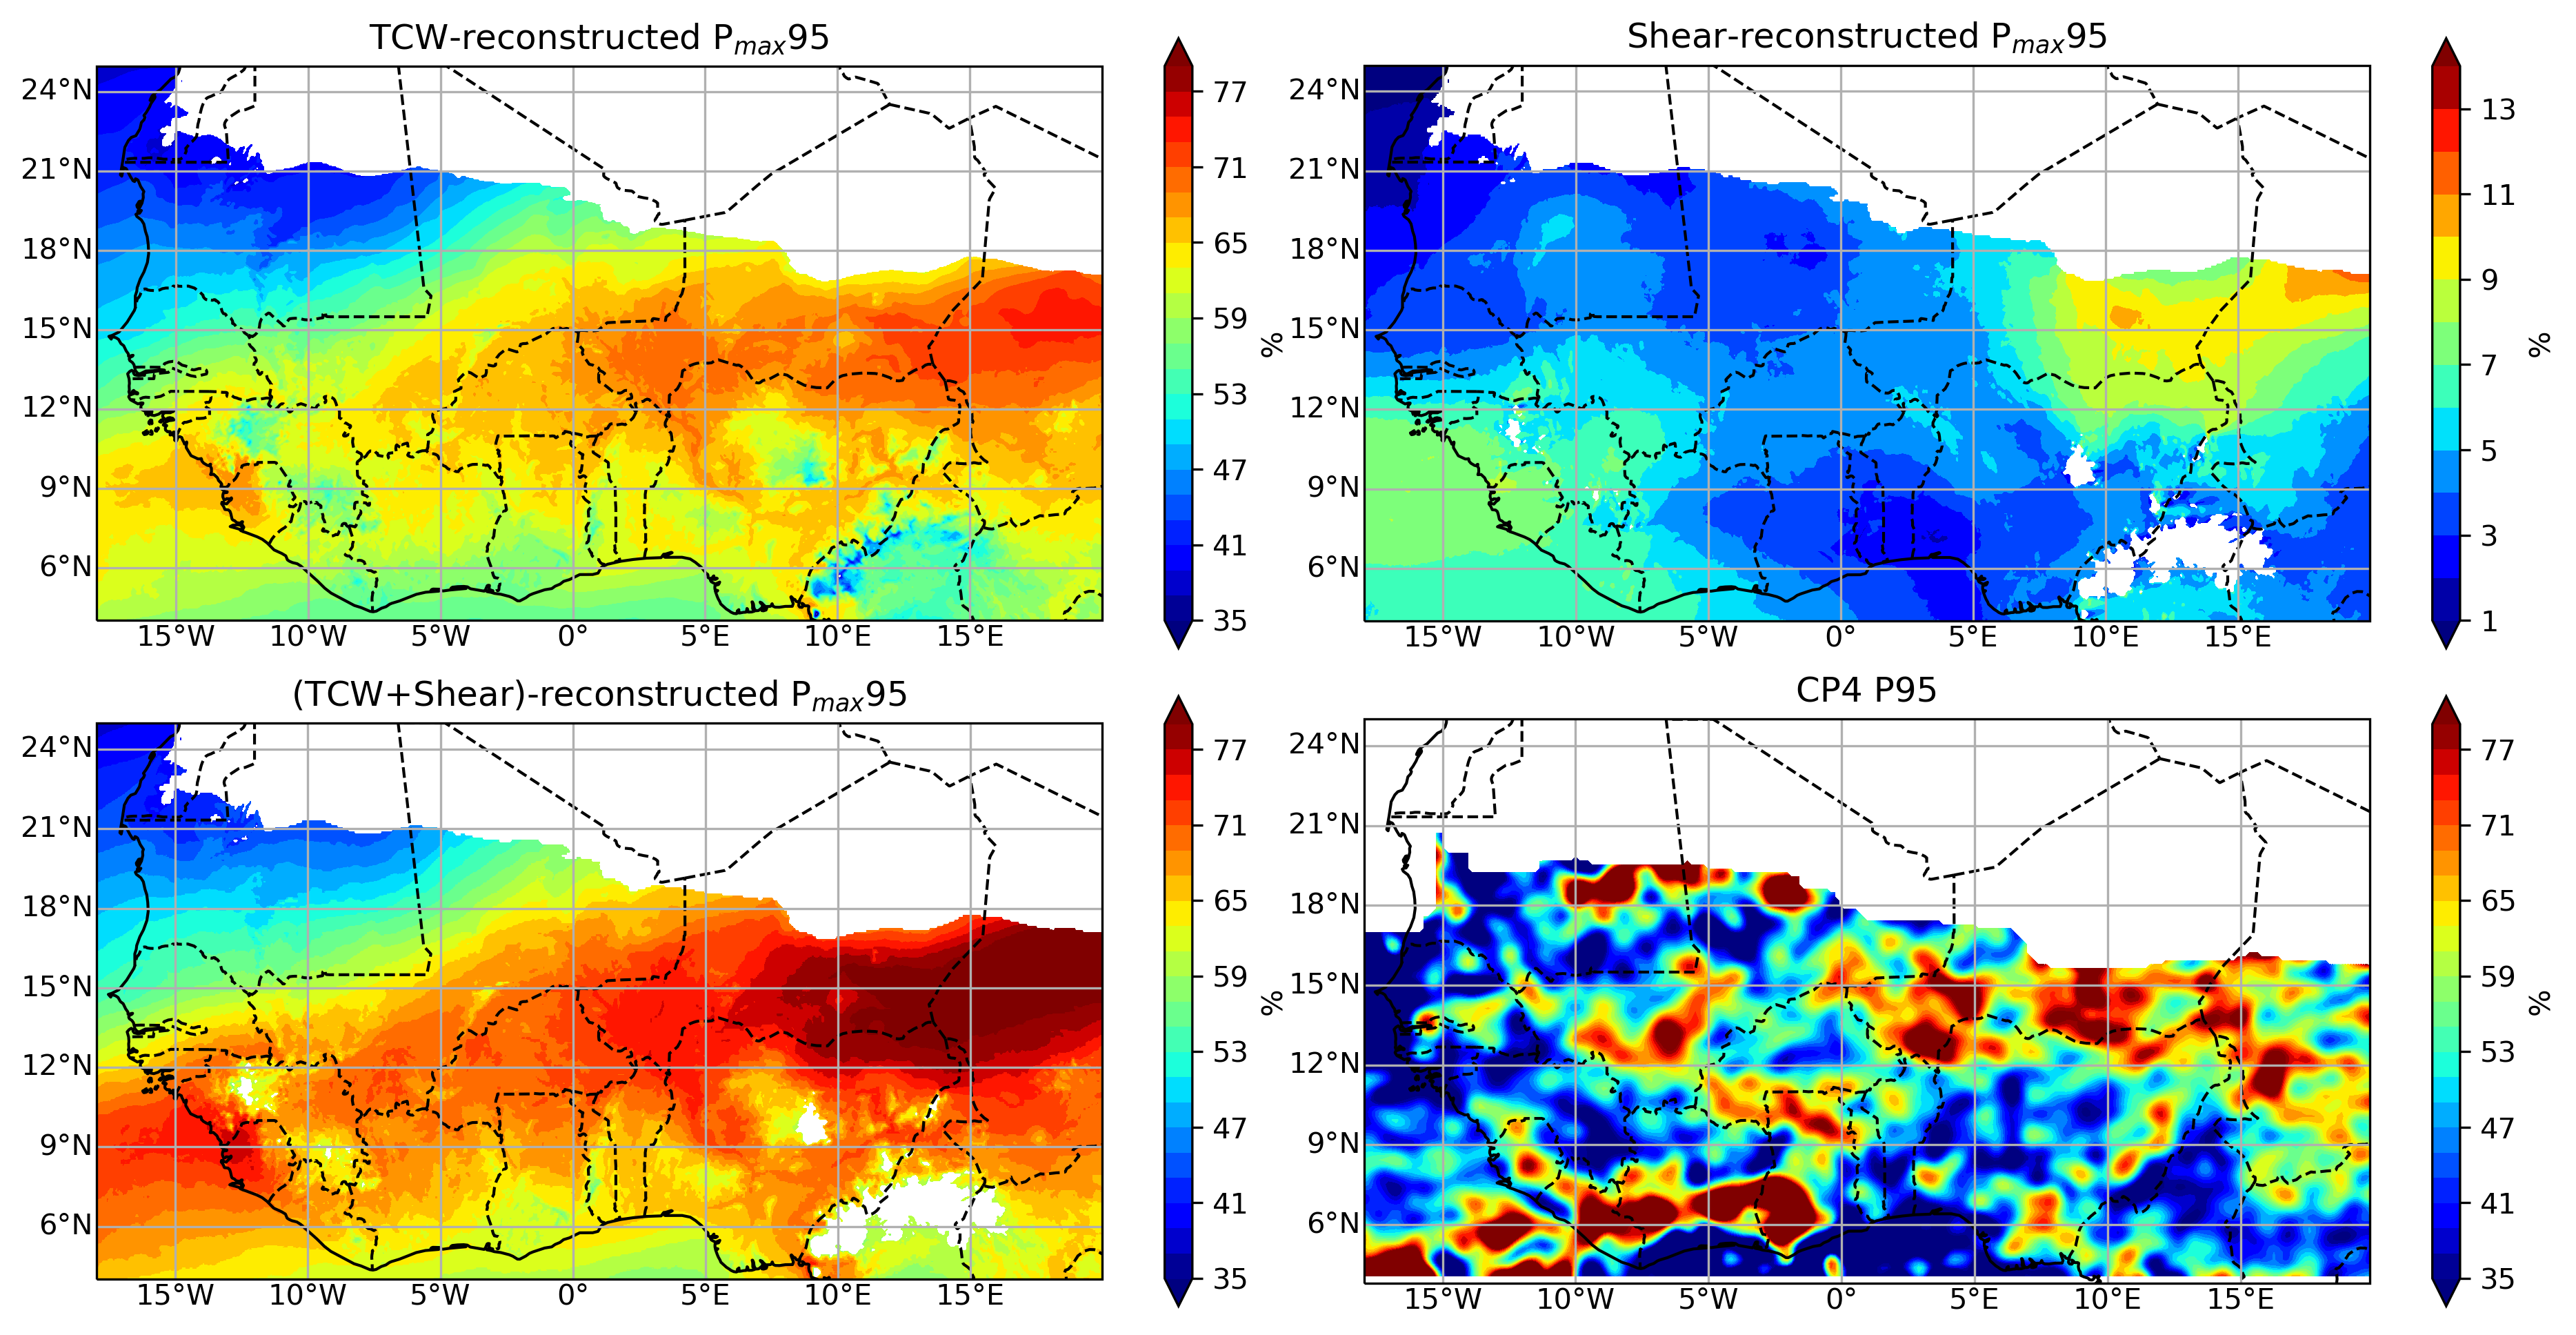

In [49]:
from scipy import ndimage
f = plt.figure(figsize=(12.5,6.5), dpi=300)
tthresh = 24.5   # 0.5th centile
thist_on_precip = fm.salem.lookup_transform(tcw_hist['tcwv'])
thist_on_shear = shear_diff.salem.transform(tcw_hist['tcwv'])
tdiff_on_shear = shear_diff.salem.transform(tcw_diff)

#ndimage.gaussian_filter(((dic2['lsta0']) / (dic2['cnt0'])), 2, mode='nearest')

ax2 = f.add_subplot(221, projection=ccrs.PlateCarree())
draw_map(ax2, tcw_diff.where(tcw_hist['tcwv']>tthresh)*tcabsfac/mmPerPercent, tcw_diff.latitude, tcw_diff.longitude, title='TCW-reconstructed P$_{max}$95', levels=np.arange(35,81,2), label=r'%')
ax3 = f.add_subplot(222, projection=ccrs.PlateCarree())
draw_map(ax3, (shear_diff.where(thist_on_shear>tthresh)*shearfac)/mmPerPercent, shear_diff.latitude, shear_diff.longitude, title='Shear-reconstructed P$_{max}$95', levels=np.arange(1,15,1), label=r'%')
ax3 = f.add_subplot(223, projection=ccrs.PlateCarree())
draw_map(ax3, ((shear_diff.where(thist_on_shear>tthresh)*shearfac)+(tdiff_on_shear.where(thist_on_shear>tthresh)*tcabsfac))/mmPerPercent, shear_diff.latitude, shear_diff.longitude, title='(TCW+Shear)-reconstructed P$_{max}$95', levels=np.arange(35,81,2), label=r'%')

ax5 = f.add_subplot(224, projection=ccrs.PlateCarree())
ax5.set_ylim(3.8,25)
draw_map(ax5, ndimage.gaussian_filter(((fm-hm)/hm*100).where(thist_on_precip>tthresh),2, mode='nearest'), fm.latitude, fm.longitude, title='CP4 P95', levels=np.arange(35,81,2), label=r'%')
plt.tight_layout()
f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CP4_reconstructed_JASrain.jpg')